<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/nursery_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 保育所
- [（認可）保育所](https://catalog.data.metro.tokyo.lg.jp/dataset/t000010d0000000099/resource/f3a1b2c5-a037-4627-9166-2a4863bf3bd9)

In [34]:
!pip install -q japanize-matplotlib

     |████████████████████████████████| 4.1 MB 7.8 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [7]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

In [50]:
nursery_url = 'https://www.opendata.metro.tokyo.lg.jp/fukushihoken/R3/202110-2-1-hoikusyo.csv'
df_nursery = get_data_csv_url(nursery_url, encoding='shift-jis')
print(df_nursery.shape)

(3431, 9)


In [51]:
df_nursery['市区町村名'] = df_nursery['所在地'].str.extract('(^.*?[区市])', expand=False)
df_nursery['施設分類'] = '認可保育所'

df_nursery_master = df_nursery[
    (df_nursery['市区町村名'].notna())&
    (df_nursery['市区町村名'].str.endswith('区'))&
    (df_nursery['市区町村名'].str.len() < 5)
][['市区町村名', '施設分類', '設置', '施設名', '所在地', '緯度', '経度', '定員']].rename(columns={'施設名':'名称'}).reset_index(drop=True)
print(df_nursery_master.shape)

assert df_nursery_master['市区町村名'].nunique() == 23

(2526, 8)


In [52]:
df_nursery_master.to_csv(os.path.join(DIR_NAME, 'nursery_master.csv'), index=False)

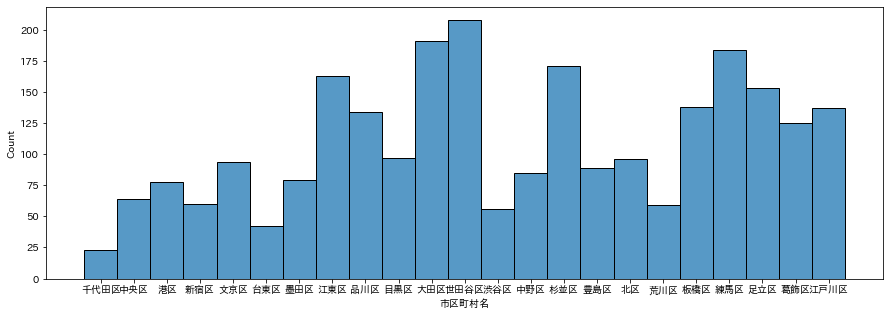

In [53]:
plt.figure(figsize=(15, 5))
sns.histplot(x='市区町村名', data=df_nursery_master)
plt.show()

### 人口マスタ

In [54]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(2921, 6)


In [55]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [56]:
%%time
# 一番近い施設の距離
df_pop_master['保育園(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '認可保育所', 'min')
# 近い3件の距離の平均
df_pop_master['保育園(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '認可保育所', 'mean', 3)
# 1km以内の施設の数
df_pop_master['保育園(数)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '認可保育所', 'count', 1)

CPU times: user 8min 40s, sys: 1.39 s, total: 8min 41s
Wall time: 8min 43s


In [57]:
print(df_pop_master.shape)
df_pop_master.head()

(2921, 9)


,地域ID,市区町村名,町名,町丁目,緯度,経度,保育園(最近傍距離),保育園(平均距離),保育園(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,0.747610,0.805902,3
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,0.841154,0.971389,1
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,0.611528,0.903572,1
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.324671,0.756240,3
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.306243,0.658302,4


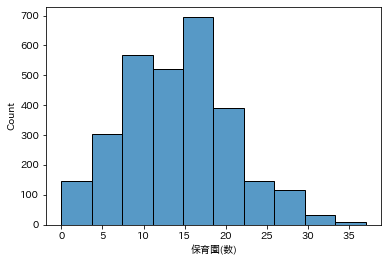

In [58]:
sns.histplot(df_pop_master['保育園(数)'], bins=10)
plt.show()

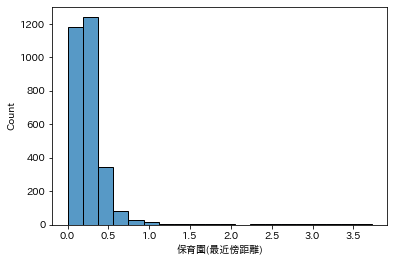

In [59]:
sns.histplot(df_pop_master['保育園(最近傍距離)'], bins=20)
plt.show()

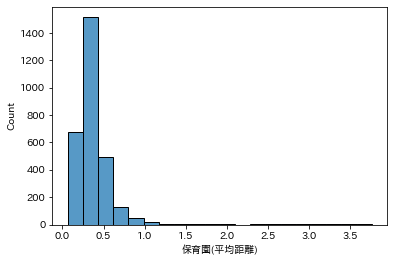

In [60]:
sns.histplot(df_pop_master['保育園(平均距離)'], bins=20)
plt.show()

In [61]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

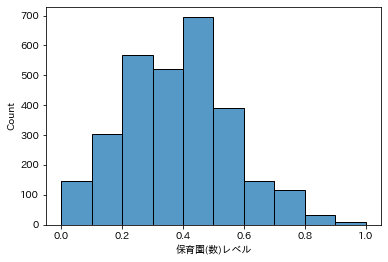

In [62]:
df_pop_master['保育園(数)レベル'] = normalize_score(df_pop_master['保育園(数)'], outlier=False)
sns.histplot(df_pop_master['保育園(数)レベル'], bins=10)
plt.show()

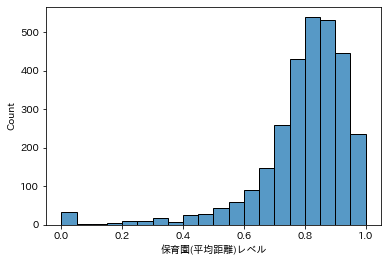

In [63]:
df_pop_master['保育園(平均距離)レベル'] = normalize_score(df_pop_master['保育園(平均距離)'], False)
sns.histplot(df_pop_master['保育園(平均距離)レベル'], bins=20)
plt.show()

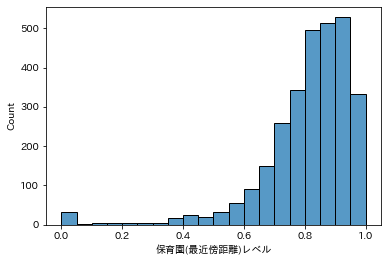

In [64]:
df_pop_master['保育園(最近傍距離)レベル'] = normalize_score(df_pop_master['保育園(最近傍距離)'], False)
sns.histplot(df_pop_master['保育園(最近傍距離)レベル'], bins=20)
plt.show()

In [65]:
score_list = [
    df_pop_master['保育園(最近傍距離)レベル'] * 1.0,
    df_pop_master['保育園(平均距離)レベル'] * 0.5,
    df_pop_master['保育園(数)レベル'] * 0.5,
]
df_pop_master['_保育園スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master['保育園スコア'] = rank_score(df_pop_master['_保育園スコア'])

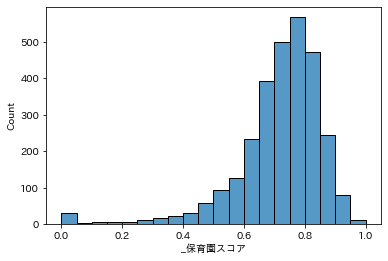

In [66]:
sns.histplot(df_pop_master['_保育園スコア'], bins=20)
plt.show()

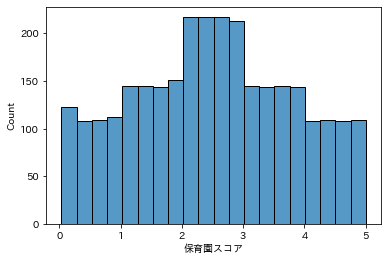

In [67]:
sns.histplot(df_pop_master['保育園スコア'], bins=20)
plt.show()

In [73]:
df_pop_master[['地域ID', '市区町村名', '町丁目', '保育園(最近傍距離)', '保育園(平均距離)', '保育園(数)', '保育園スコア']]\
    .to_csv(os.path.join(DIR_NAME, 'nursery_score.csv'), index=False)

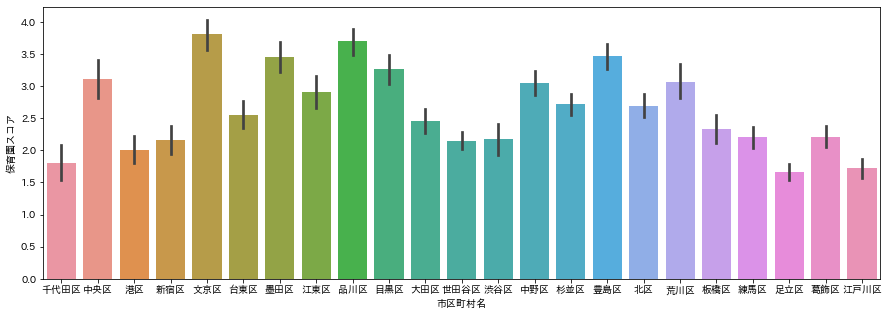

In [69]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y='保育園スコア', data=df_pop_master)
plt.show()

In [70]:
df_library_level = df_pop_master.copy()
df_library_level['rank'] = df_library_level.groupby('町名')['保育園スコア'].transform('rank', ascending=False)
df_library_level = df_library_level[df_library_level['rank'] == 1].sort_values('保育園スコア', ascending=False)[
    ['市区町村名', '町名', '町丁目', '保育園スコア', '_保育園スコア', '保育園(最近傍距離)', '保育園(平均距離)', '保育園(数)']
].reset_index(drop=True)
print(df_library_level.shape)

(697, 8)


In [71]:
df_library_level.head(20)

,市区町村名,町名,町丁目,保育園スコア,_保育園スコア,保育園(最近傍距離),保育園(平均距離),保育園(数)
0,江東区,森下,森下３丁目,5.000000,1.000000,0.010684,0.078456,34
1,墨田区,立川,立川２丁目,4.997711,0.972411,0.080975,0.149261,34
2,品川区,東中延,東中延２丁目,4.995423,0.970582,0.037886,0.146473,31
3,中央区,日本橋浜町,日本橋浜町１丁目,4.993134,0.970302,0.021259,0.136044,30
4,墨田区,緑,緑３丁目,4.990846,0.966604,0.034921,0.171510,31
5,墨田区,千歳,千歳３丁目,4.986268,0.958568,0.035699,0.208362,31
6,墨田区,菊川,菊川１丁目,4.983980,0.958324,0.110534,0.189642,35
7,中央区,日本橋堀留町,日本橋堀留町２丁目,4.979403,0.955642,0.034451,0.074225,28
8,文京区,千石,千石３丁目,4.977114,0.954410,0.096463,0.170944,33
9,中央区,日本橋人形町,日本橋人形町３丁目,4.970248,0.944606,0.040117,0.134248,27


In [72]:
df_library_level.tail(20)

,市区町村名,町名,町丁目,保育園スコア,_保育園スコア,保育園(最近傍距離),保育園(平均距離),保育園(数)
677,足立区,西伊興,西伊興１丁目,0.663691,0.554635,0.424303,0.560199,7
678,足立区,堀之内,堀之内２丁目,0.636228,0.546498,0.402952,0.576460,5
679,千代田区,神田錦町,神田錦町１丁目,0.585879,0.535330,0.409772,0.583052,4
680,大田区,平和島,平和島１丁目,0.576725,0.532483,0.445365,0.656388,8
681,大田区,昭和島,昭和島１丁目,0.546973,0.525864,0.436216,0.574676,4
682,板橋区,四葉,四葉１丁目,0.542396,0.524412,0.531414,0.586389,10
683,江戸川区,北篠崎,北篠崎１丁目,0.359309,0.468931,0.511514,0.727174,5
684,江東区,新砂,新砂１丁目,0.322691,0.457833,0.653698,0.689703,11
685,千代田区,永田町,永田町２丁目,0.276920,0.427942,0.637925,0.666758,5
686,足立区,古千谷,古千谷２丁目,0.235725,0.402898,0.627583,0.741541,3
